# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

_, processed_census_income_kdd = load_dataset('census_income_kdd')
processed_census_income_kdd.head(3)

age                                           0
workclass                                     0
industry_code                                 0
occupation_code                               0
education                                     0
wage_per_hour                                 0
enrolled_in_edu_inst_last_wk                  0
marital_status                                0
major_industry_code                           0
major_occupation_code                         0
race                                          0
hispanic_origin                               0
sex                                           0
member_of_a_labour_union                      0
reason_for_unemployment                       0
employment_status                             0
capital_gains                                 0
capital_losses                                0
dividend_from_stocks                          0
tax_filler_status                             0
region_of_previous_residence            

,age,wage_per_hour,capital_gains,capital_losses,dividend_from_stocks,instance_weight,num_persons_worked_for_employer,weeks_worked_in_year,sex,workclass_ Federal government,...,own_business_or_self_employed_2,fill_inc_questionnaire_for_veteran's_admin_ No,fill_inc_questionnaire_for_veteran's_admin_ Not in universe,fill_inc_questionnaire_for_veteran's_admin_ Yes,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,year_94,year_95,class
0,1.706939,-0.203989,-0.093502,-0.138177,-0.10222,-0.043817,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,1.030500,-0.203989,-0.093502,-0.138177,-0.10222,-0.691534,-0.421771,1.158280,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
2,-0.773339,-0.203989,-0.093502,-0.138177,-0.10222,-0.753246,-0.843184,-0.970621,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1


### 3. Split label/unlabel data, split train/test data.

In [4]:
'''Census income kdd dataset'''
df = processed_census_income_kdd.copy()
# 随机抽取 10% 的数据 ------ 因为数据量实在太大了，计算太慢了
sampled_df = df.sample(frac=0.1, random_state=42)
# 重置索引
sampled_df = sampled_df.reset_index(drop=True)
X = sampled_df.drop('class', axis=1)
y = sampled_df['class']



# 10% X_label, 90% X_unlabel
X_label, X_unlabel, y_label, y_unlabel = train_test_split(X, y, test_size=0.9, random_state=25) 
print(f'X_label shape: {X_label.shape}')
print(f'X_unlabel shape: {X_unlabel.shape}')
print('---------------------------------')
# split labeled data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_label shape: (2860, 505)
X_unlabel shape: (25748, 505)
---------------------------------
X_train shape: (2002, 505)
X_test shape: (858, 505)


### 4. Train the original model

In [5]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9324009324009324


In [6]:
from src.baselines import Baseline

baseline = Baseline(X_train, y_train, X_test, y_test, X_unlabel, model='xgboost')
baseline.get_baseline1()

c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-18 21:39:34.219 | INFO     | src.baselines:get_baseline1:44 - baseline1: 使用了xgboost, Accuracy: 0.932, DR: 0.05243


In [7]:
'''
使用nearest neighbour在unlabel data中挑选与X_train相近的数据, 他们label使用与之匹配的X_train的label, 然后加入training set.   (结果不行)
'''
baseline.get_baseline2()

2025-01-18 21:39:41.070 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 1, Accuracy: 0.932, DR: 0.04044
2025-01-18 21:39:42.226 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 2, Accuracy: 0.930, DR: 0.03588
2025-01-18 21:39:43.558 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.2, num_new_data: 3, Accuracy: 0.929, DR: 0.03357
2025-01-18 21:39:44.504 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 1, Accuracy: 0.935, DR: 0.04369
2025-01-18 21:39:45.940 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 2, Accuracy: 0.932, DR: 0.03944
2025-01-18 21:39:47.973 | INFO     | src.baselines:get_baseline2:70 - baseline2: 使用了xgboost, proportion: 0.4, num_new_data: 3, Accuracy: 0.928, DR: 0.03177
2025-01-18 21:39:49.188 | INFO     | src.baselines:get_baseline2

In [8]:
'''
使用nearest neighbour在unlabel data中挑选与X_train相近的数据, 直接把挑选出来的数据输入进model, 预测结果作为新的label, 然后加入training set. （效果很好）
'''
baseline.get_baseline3()

2025-01-18 21:40:02.159 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 1, Accuracy: 0.932, DR: 0.03161
2025-01-18 21:40:03.802 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 2, Accuracy: 0.932, DR: 0.02571
2025-01-18 21:40:05.680 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.2, num_new_data: 3, Accuracy: 0.932, DR: 0.02099
2025-01-18 21:40:07.190 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 1, Accuracy: 0.935, DR: 0.02737
2025-01-18 21:40:09.290 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 2, Accuracy: 0.932, DR: 0.02648
2025-01-18 21:40:11.868 | INFO     | src.baselines:get_baseline3:105 - baseline3: 使用了xgboost, proportion: 0.4, num_new_data: 3, Accuracy: 0.935, DR: 0.02195
2025-01-18 21:40:13.807 | INFO     | src.baselines:get_bas

### 5. Start the experiment!

>1. 只使用10%的labeled data 查看模型结果-baseline （见4, 5）
>
>2. 只使用10%的labeled data + sex balance查看模型结果
>
>3. 使用10%的labeled data， 再使用unlabel data把labeled data中的sex补齐。（使用model预测的值对unlabel data贴标签）
>
>4. 使用10%的labeled data， 再使用unlabel data时候，让新增的data中 sex balanced（使用model预测的值对unlabel data贴标签）
>
>5. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 使用labeled data中最相似的instance的标签
>
>6. 使用10%的labeled data + sex balance + new data (from unlabeled data) + sex balance + 通过pretrained model对data进行label标注
>
>7.☆☆  这里的sex balance是如何选取好点？ 是分别找sex=0和sex=1的nearest neighbour(此处数量怎么限制？按照少数的来？)。
>   还是把他们放在一个大池子里。统一挑出来，最后再限制个数为min(num_sex0, num_sex1)， 如果这样的话，对unlabeled data标注方式感觉不能直接使用原标签，是否用ml预测的结果会更好一点？

In [9]:
from src.experiments import Experiment

In [17]:
my_experiment = Experiment(
            orginal_model=model, 
            X_train=X_train, 
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_unlabel=X_unlabel,
            y_unlabel=y_unlabel,
            dataset_name='census_income_kdd', )
'''
对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 1)中的1改成50
'''

'\n对于german credit，需要把 self.limited_values_range = np.arange(1, non_zero_count, 1)中的1改成50\n'

In [19]:
# new_models_DR_values = my_experiment.get_result(
#             sex_balance = False, 
#             proportion = 0.5,
#             replacement = True, 
#             num_new_data = 3,
#             matcher = 'nn')

new_models_DR_values,_ = my_experiment.get_sex_separate_nn_result(
    sex_balance=False,
    proportion=0.6,
    replacement=True,
    num_new_data=3,
    matcher='nn',
    match_method='sex_separate'
)


开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 15513
Proporation: 0.6, new_data_number: 3 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------


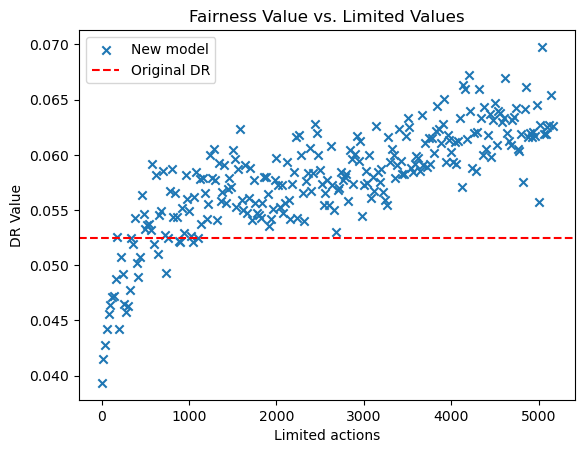

In [ ]:
'''
考虑到这个dataset有大量的改动没有用，只会增加DR值，所以我选择了只改动 number_actions的1/3个数
'''

my_experiment.visualize(new_models_DR_values)

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 4939
Proporation: 0.4, new_data_number: 1 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 9916
Proporation: 0.4, new_data_number: 2 训练结束, match_method:together,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X

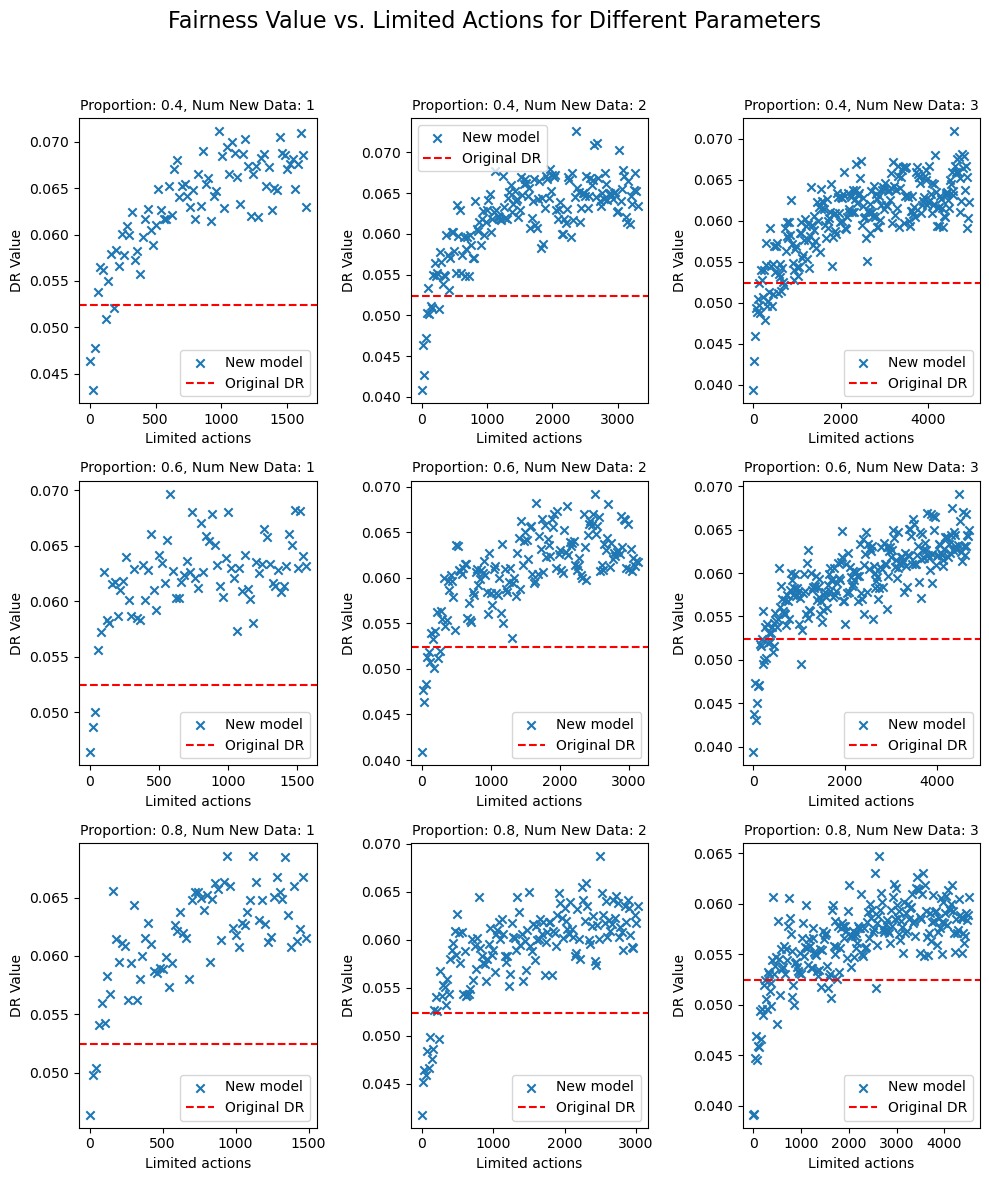

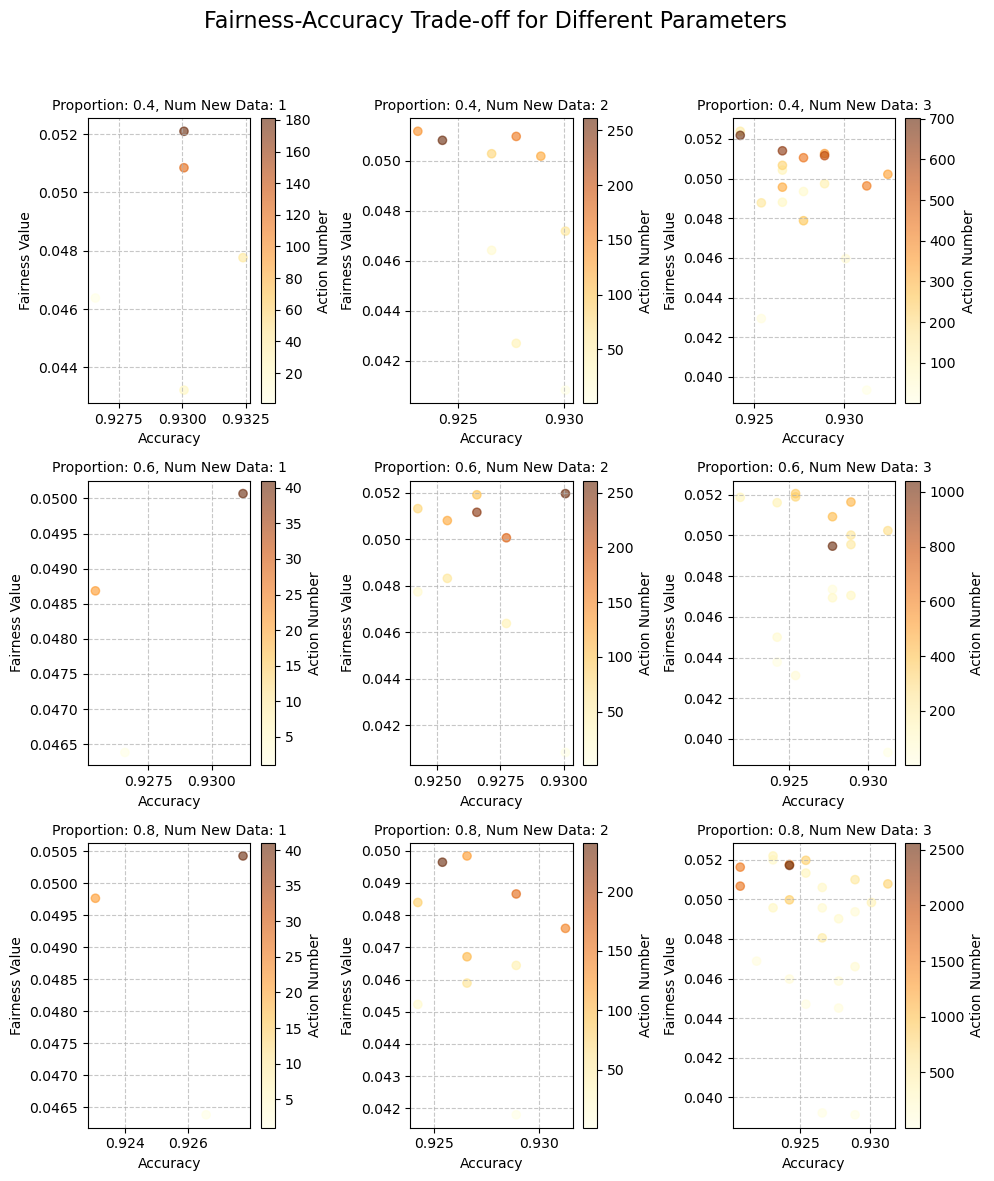

In [21]:
results = my_experiment.combination(match_met='together')

开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 5433
Proporation: 0.4, new_data_number: 1 训练结束, match_method:sex_separate,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第1步, 从X_unlabel中按照比例随机抽出num_new_data组数据
开始第2步, X_label分别与random_picks[0,1,2....,num_new_data-1]进行matching, 找到matching的数据
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 10995
Proporation: 0.4, new_data_number: 2 训练结束, match_method:sex_separate,DR值已经保

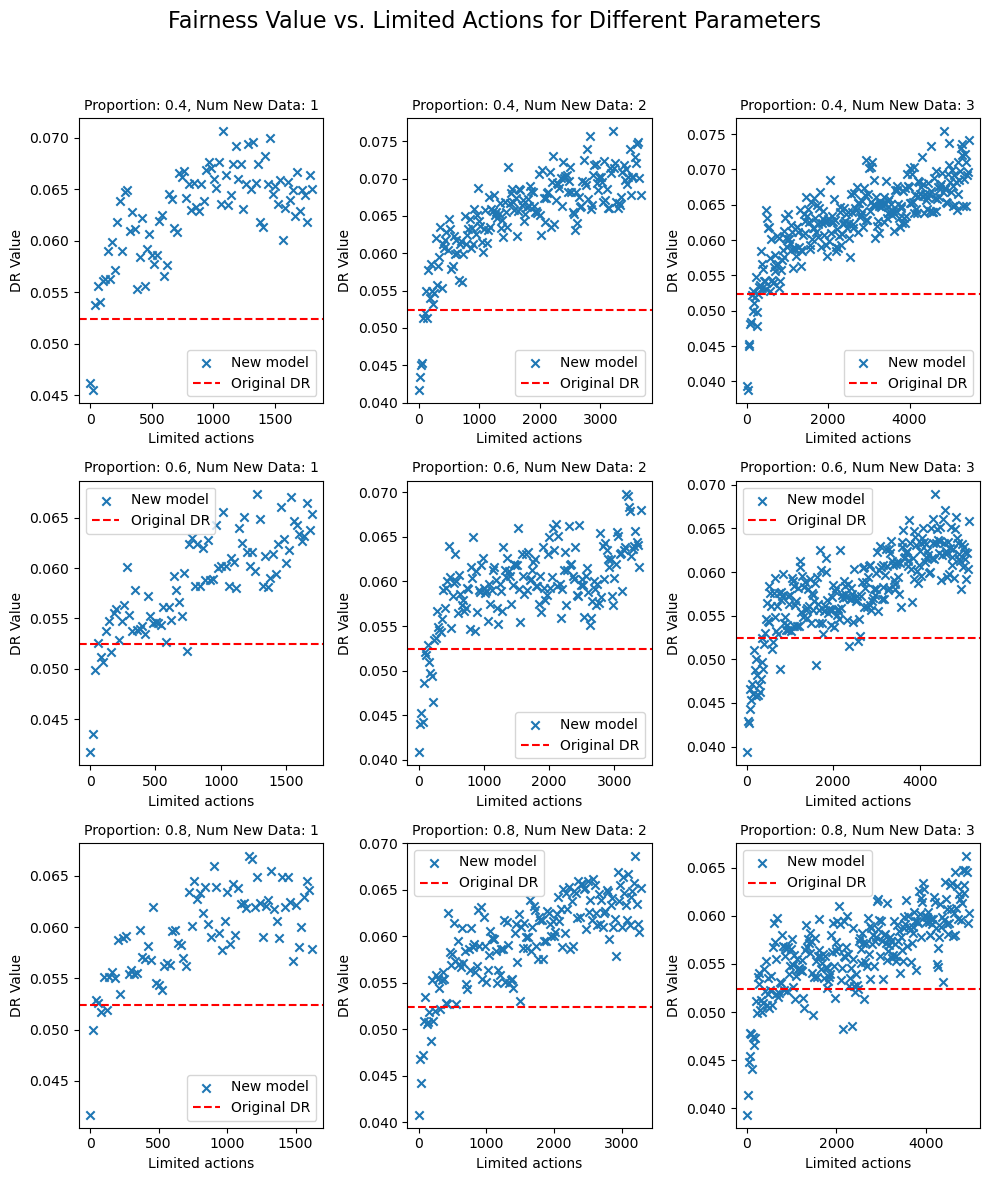

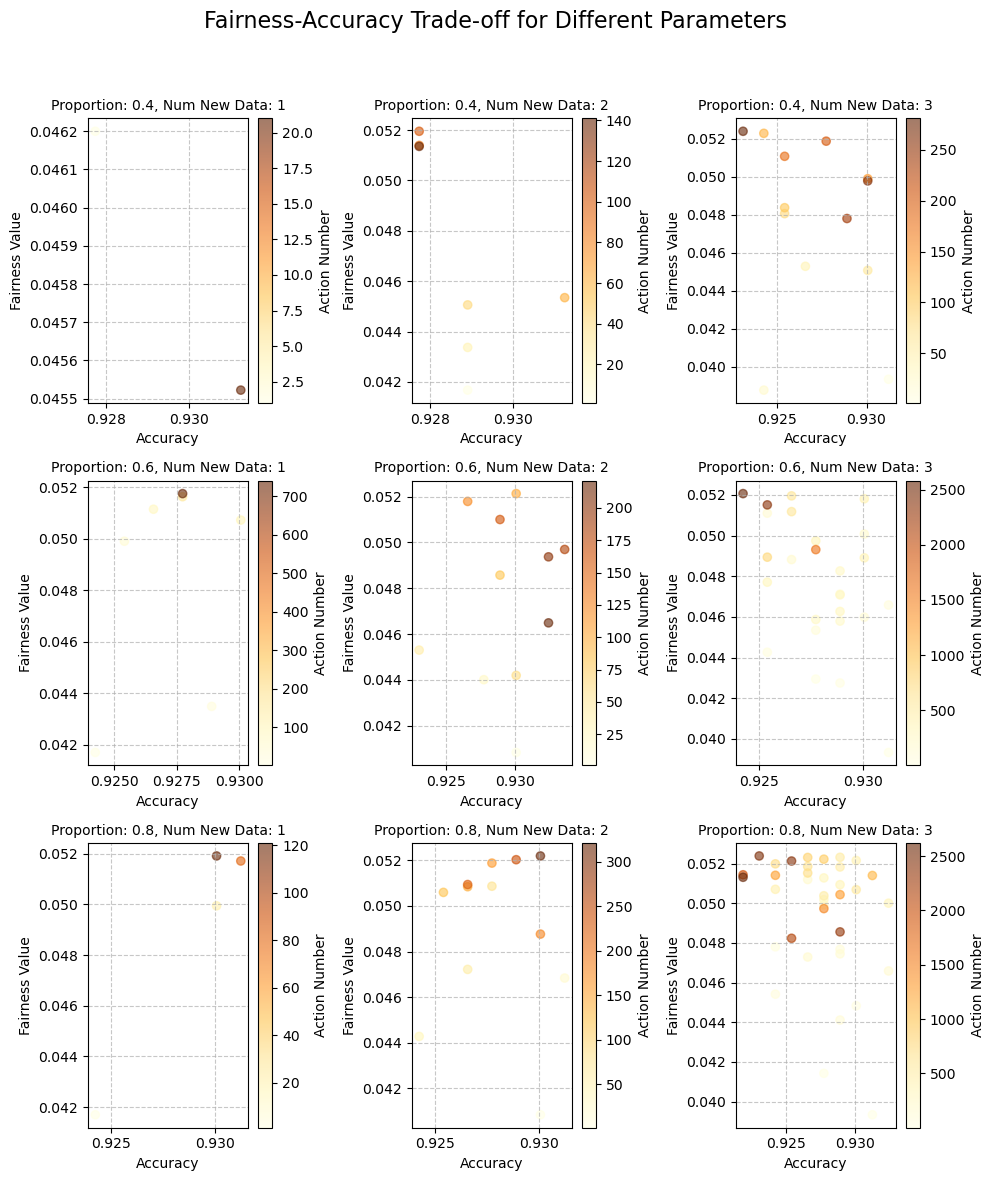

In [23]:
results_sex_separate = my_experiment.combination(match_met='sex_separate')

开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 5588
Proporation: 0.4, new_data_number: 1 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加入到X_train中, 返回合并后的数据, 重新训练模型, 并且评估性能
Total number of non-zero values across all varphis: 11036
Proporation: 0.4, new_data_number: 2 训练结束, match_method:sex_cross,DR值已经保存, 可以进行可视化
-----------------------------------------------------------------------------
开始第3步, 计算每组数据的fairness shapley value
开始第4步, 对shapely value不取绝对值, 然后把负值直接变成0, 然后在归一化, 得到新的varphi
开始第5步, 计算q
开始第6步, 计算出总共可以修改的actions number, 并且把新的unlabel data整合好, 加

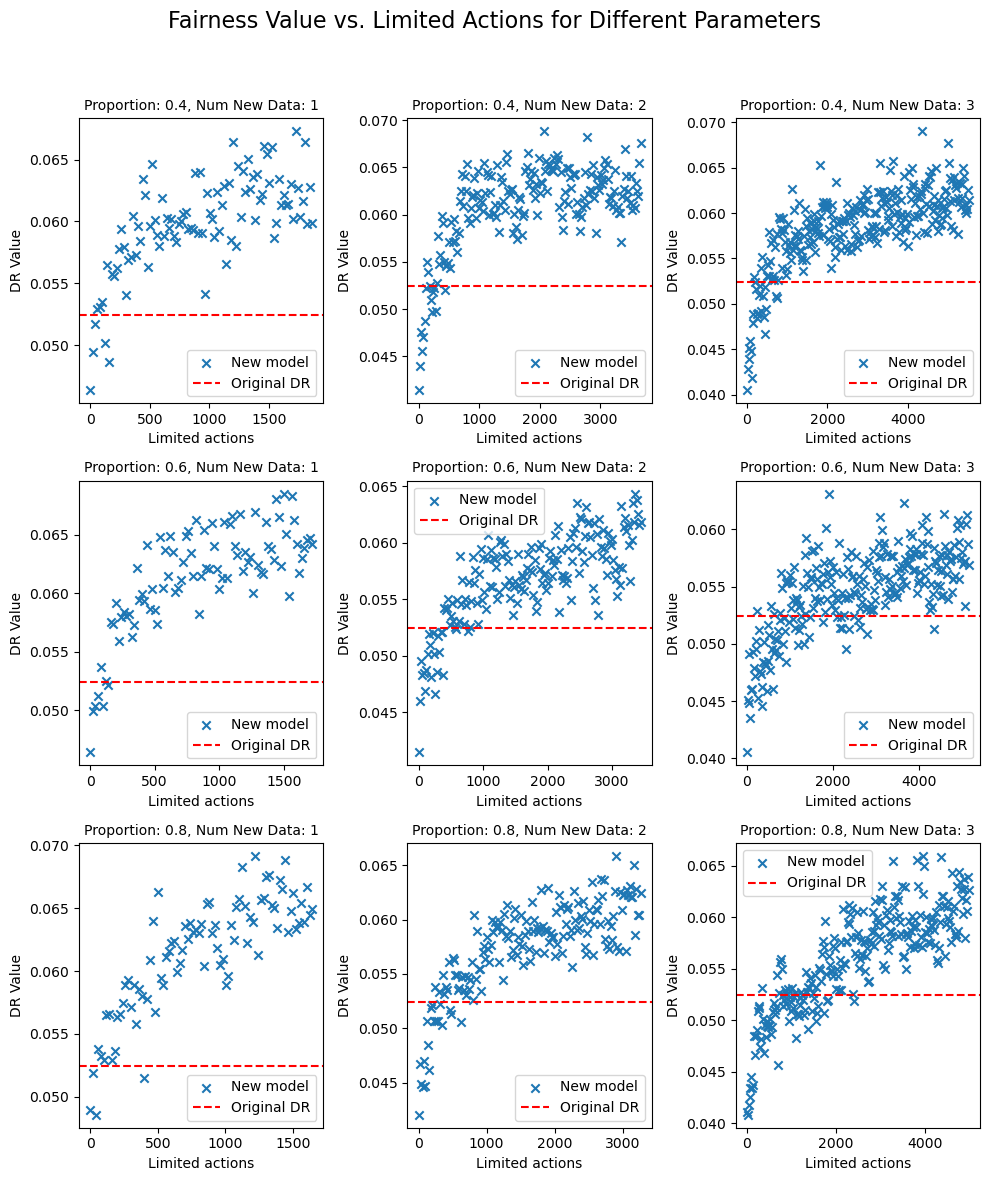

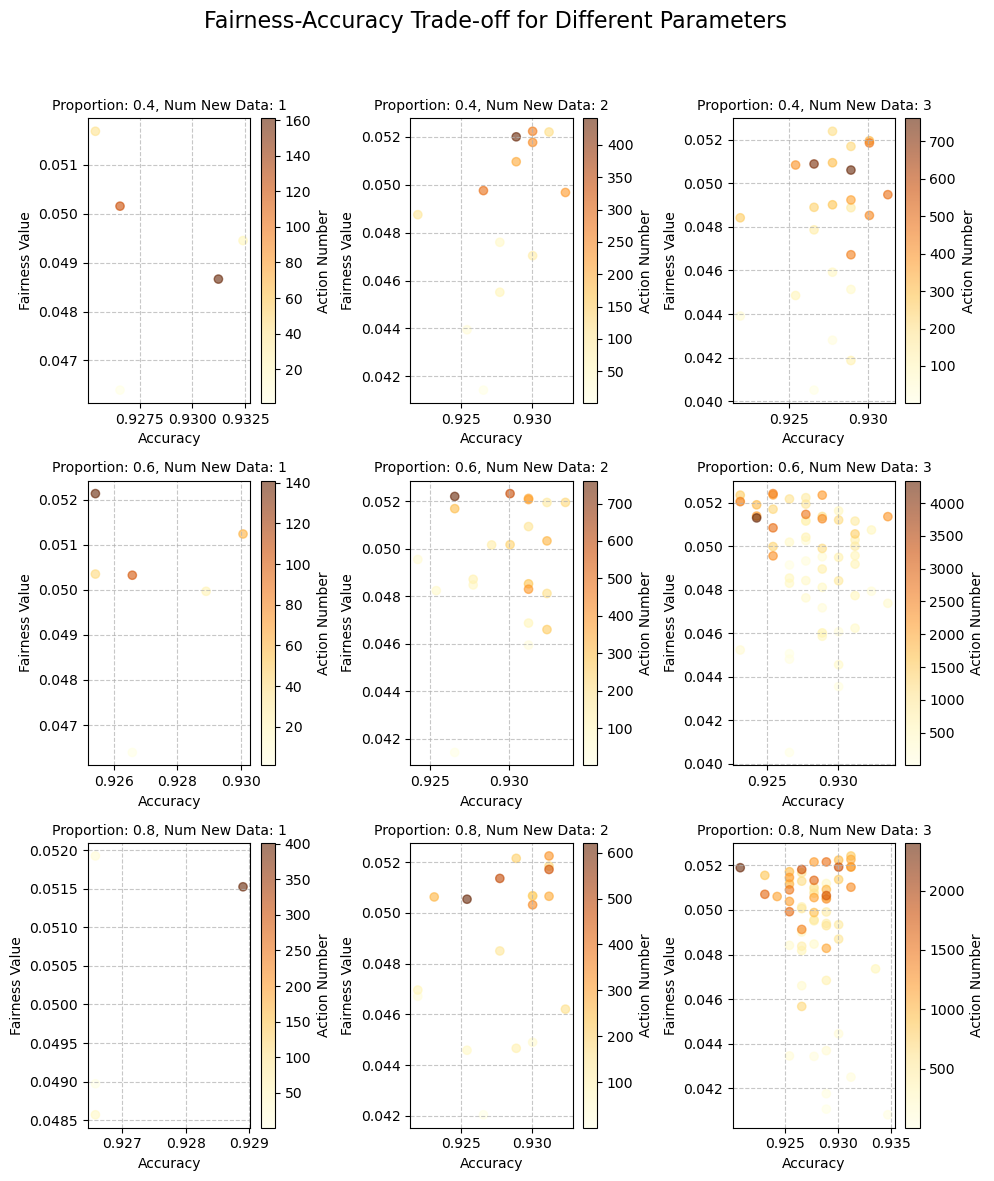

In [24]:
results_sex_cross = my_experiment.combination(match_met='sex_cross')